## Object criticality for better and safer navigation

**GOAL2 analysis**

This is the detailed analysis of results for GOAL2. It works for a selected detector *one at at time*. So it needs to be re-executed for every detector that is considered.

Very practically,

- it runs pkl keeping bounding boxes above a certain criticality. Overall, resulting PKL should be lower than the "traditional" approach to object detection and PKL.


- then it compares frames with/without our approach, to see the difference in the computed PKL. It created 2 ordered list, i) frames where traditional approach is better; ii) frames where our GOAL2 approach is better


- visualize everything


- select target token that you want to inspect. Recompute everything just to have the data for visualization and manipulation of the image. Try to position the ground truth at time zero, and at time t+something (e.g., 3 seconds in the future, 4 seconds in the future). This will show how the planned trajectory would be overlapping to the actual system behaviour.

In [44]:
import numpy as np
import os
import itertools
import unittest
import sklearn
import tqdm
import pandas
import math
import json
from typing import Callable
from nuscenes import NuScenes
from nuscenes.eval.prediction.splits import *
import nuscenes.eval.detection.config as cnfig
from nuscenes.eval.detection.configs import *
from nuscenes.eval.detection.data_classes import DetectionBox 
from nuscenes.eval.detection import *
import nuscenes.eval.detection.algo as ag
from nuscenes.eval.detection.data_classes import DetectionMetricData, DetectionConfig, DetectionMetrics, DetectionBox, \
    DetectionMetricDataList
from nuscenes.eval.common.data_classes import EvalBoxes
from typing import List, Dict, Callable, Tuple
from nuscenes.eval.common.utils import center_distance, scale_iou, yaw_diff, velocity_l2, attr_acc, cummean
import nuscenes.eval.detection.evaluate as dcl    
from nuscenes.prediction import *
from nuscenes.map_expansion.map_api import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import torch
import json
import numpy as np
import cv2
from pyquaternion import Quaternion
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

from pkl.models import compile_model

*recommend not changing these*

In [82]:
test=True #does reduced runs, with fewer parameters
verbose=False #avoid so much printing, checks, elaborations, ...

**Configuration items**

Configuration parameters. Rather intuitive: 

* GOAL must be GOAL2

* decide if you want only cars or all objects


In [83]:
GOAL="GOAL2" #set GOAL2, GOAL3, GOAL4 depending what to evaluate

car_only=False #filters out all non-car objects

* set target D, R, T, threshold, criticality. To understand the proper values, We recommend to rely on the results of the other jupyter that runs everything repeatedly.

Relevant configuration we tested:
 * REG, D=10, R=10, T=4, crit=0.8, threshold=0.55, car_only=False
 * SSN, D=10, R=10, T=4, crit=0.8, threshold=0.35, car_only=True

In [84]:
object_classes=['car', 'truck', 'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 'bicycle', 'traffic_cone', 'barrier']    
object_classes_reduced=['car']

if car_only:
    object_classes=object_classes_reduced


D=10

R=10

T=4

crit=0.9

threshold=0.55

* set the paths to the correct folders.

In [85]:
nworkers=10 # number of workers for dataloader: depends on your resources!
bsz= 128# batch size for dataloader: depends on your resources!
gpuid=0 #id of the gpu; -1 if no GPU

#base path for the notebook (home directory)
NOTEBOOK_HOME='/home/notebook/'
    
#nuscene dataset install folder
DATAROOT=NOTEBOOK_HOME+'nuscene/data'

#pkl path to planner.pt and masks_trainval.json
modelpath=NOTEBOOK_HOME+'pkl/Evaluation-Of-Safety-Oriented-Metrics-for-Object-Detectors/metrics_model/planner.pt'
mask_json=NOTEBOOK_HOME+'pkl/Evaluation-Of-Safety-Oriented-Metrics-for-Object-Detectors/metrics_model/masks_trainval.json'

#results of the object detectors (result_nusc.json) are stored here, in subdirectories:
#PATH+DETECTOR+FILE_JSON
#e.g. '/home/notebook/pkl/result_objdet/PGD/results_nusc.json'
PATH=NOTEBOOK_HOME+'pkl/result_objdet/'
FILE_JSON='/results_nusc.json'

#results computed are stored here. Subfolders will be created, like:
#/home/notebook/pkl/results/PGD/'
RESULTS_PATH=NOTEBOOK_HOME+'pkl/results/GOAL2/'

#how many images in bird view you want to draw
NUMBER_IMAGE=0

Set the detector you are inspecting

In [86]:
if test:
    DETECTOR= {"SSN": 'SSN'}
else:
    #the object detector that were experimented on nuscenes
    DETECTOR= {#"RegNetX-1.6gF-FPN":'REG',
            #"SECFPN": 'SECFPN',
            #"PointPillars": 'POINTP',
            #"SSN": 'SSN',
            #"PGD": 'PGD',
            #"FCOS3D": 'FCOS3D',
            }


Following is whole code

In [87]:
nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)
confvalue=cnfig.config_factory("detection_cvpr_2019")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 35.958 seconds.
Reverse indexing ...
Done reverse indexing in 8.4 seconds.


In [88]:
#number of scene that compose the val set
eval=val = ['scene-0013',
            'scene-0554',
            'scene-0771',
            'scene-0929',
            'scene-1070',
            'scene-1072',
            'scene-0798',
            'scene-0108',
            'scene-0519',
            'scene-0332',]

'''
        ['scene-0003', 'scene-0012', 'scene-0013', 'scene-0014', 'scene-0015', 'scene-0016', 'scene-0017', 'scene-0018',
         'scene-0035', 'scene-0036', 'scene-0038', 'scene-0039', 'scene-0092', 'scene-0093', 'scene-0094', 'scene-0095',
         'scene-0096', 'scene-0097', 'scene-0098', 'scene-0099', 'scene-0100', 'scene-0101', 'scene-0102', 'scene-0103',
         'scene-0104', 'scene-0105', 'scene-0106', 'scene-0107', 'scene-0108', 'scene-0109', 'scene-0110', 'scene-0221',
         'scene-0268', 'scene-0269', 'scene-0270', 'scene-0271', 'scene-0272', 'scene-0273', 'scene-0274', 'scene-0275',
         'scene-0276', 'scene-0277', 'scene-0278', 'scene-0329', 'scene-0330', 'scene-0331', 'scene-0332', 'scene-0344',
         'scene-0345', 'scene-0346', 'scene-0519', 'scene-0520', 'scene-0521', 'scene-0522', 'scene-0523', 'scene-0524',
         'scene-0552', 'scene-0553', 'scene-0554', 'scene-0555', 'scene-0556', 'scene-0557', 'scene-0558', 'scene-0559',
         'scene-0560', 'scene-0561', 'scene-0562', 'scene-0563', 'scene-0564', 'scene-0565', 'scene-0625', 'scene-0626',
         'scene-0627', 'scene-0629', 'scene-0630', 'scene-0632', 'scene-0633', 'scene-0634', 'scene-0635', 'scene-0636',
         'scene-0637', 'scene-0638', 'scene-0770', 'scene-0771', 'scene-0775', 'scene-0777', 'scene-0778', 'scene-0780',
         'scene-0781', 'scene-0782', 'scene-0783', 'scene-0784', 'scene-0794', 'scene-0795', 'scene-0796', 'scene-0797',
         'scene-0798', 'scene-0799', 'scene-0800', 'scene-0802', 'scene-0904', 'scene-0905', 'scene-0906', 'scene-0907',
         'scene-0908', 'scene-0909', 'scene-0910', 'scene-0911', 'scene-0912', 'scene-0913', 'scene-0914', 'scene-0915',
         'scene-0916', 'scene-0917', 'scene-0919', 'scene-0920', 'scene-0921', 'scene-0922', 'scene-0923', 'scene-0924',
         'scene-0925', 'scene-0926', 'scene-0927', 'scene-0928', 'scene-0929', 'scene-0930', 'scene-0931', 'scene-0962',
         'scene-0963', 'scene-0966', 'scene-0967', 'scene-0968', 'scene-0969', 'scene-0971', 'scene-0972', 'scene-1059',
         'scene-1060', 'scene-1061', 'scene-1062', 'scene-1063', 'scene-1064', 'scene-1065', 'scene-1066', 'scene-1067',
         'scene-1068', 'scene-1069', 'scene-1070', 'scene-1071', 'scene-1072', 'scene-1073']
''';

In [89]:
len(eval)

10

In [90]:
#get the list of tokens in the val set (150 scenes), put it in a file to be used as input
scenes_list=[]
counter=0

for i in nuscenes.scene:
    name=i['name']
    if(name in val):
        counter=counter+1
        scenes_list.append(i)

validation_samples={}
for i in scenes_list:
    scene_name=i['name']
    sample_token_list=[]
    first_sample_token=i['first_sample_token']
    last_sample_token=i['last_sample_token']
    current_sample_token=first_sample_token
    sample_token_list.append(current_sample_token)
    if(sample_token_list[0]!=first_sample_token):
        print("error")
        break
    while(current_sample_token!=last_sample_token):
        sample=nuscenes.get('sample', current_sample_token)
        current_sample_token=sample['next']
        sample_token_list.append(current_sample_token)
    if(sample_token_list[len(sample_token_list)-1]!=last_sample_token):
        print("error")
        break
    
    validation_samples.update({scene_name:sample_token_list})

listtoken=[]
for i in validation_samples.keys():
    listtoken.extend(validation_samples[i])

with open(RESULTS_PATH+"/token_list.json", "w") as outfile: 
    json.dump(validation_samples, outfile)

In [91]:
def create_dt(detector_file="none",
              val='val',
              model='none',
              d=1,
              r=1,
              t=1,
              verbose=False,
              recall_type="PRED AL NUMERATORE",
              nworkers=10, #for pkl
              bsz= 128, #for pkl
              gpuid=0# GPU ID, -1 if CPU only
             ):

    
    dt=dcl.DetectionEval(nusc=nuscenes,
        config=confvalue,
        result_path=detector_file,
        eval_set=val,
        model_name=model,
        MAX_DISTANCE_OBJ=d,
        MAX_DISTANCE_INTERSECT=r,
        MAX_TIME_INTERSECT_OBJ=t,
        verbose=verbose,
        recall_type="PRED AL NUMERATORE",
        nworkers=nworkers,
        bsz=bsz,
        gpuid=gpuid,
        )
    
    return dt

In [92]:
def compute_crit_pkl(dt,
                     listtoken=[],
                     conf_th_list=[0.4],
                     dist_list=[2.0],
                     crit_list=[0.5],
                     object_classes='car',
                     verbose=False,
                     model_loaded=False,#an attempt to load the model outside the pkl
                     model_object=None):

    results= dt.safety_metric_evaluation(
                    list_of_tokens=listtoken,
                    conf_th_list=conf_th_list,
                    dist_list=dist_list,
                    crit_list=criticalities,
                    obj_classes_list=object_classes, 
                    render_images=False,
                    verbose=verbose,
                    model_loaded=True,#an attempt to load the model outside the pkl
                    model_object=model_object,
                    )
    
    return results

In [93]:
def compute_crit_pkl_GOAL2(dt,
                     listtoken=[],
                     conf_th_list=[0.4],
                     dist_list=[2.0],
                     crit_list=[0.5],
                     object_classes='car',
                     verbose=False,
                     model_loaded=False,#an attempt to load the model outside the pkl
                     model_object=None):

    results= dt.safety_metric_evaluation_GOAL2(
                    list_of_tokens=listtoken,
                    conf_th_list=conf_th_list,
                    dist_list=dist_list,
                    crit_list=criticalities,
                    obj_classes_list=object_classes, 
                    render_images=False,
                    verbose=verbose,
                    model_loaded=model_loaded,#an attempt to load the model outside the pkl
                    model_object=model_object,
                    )
    return results

load pkl model

In [94]:
# constants related to how the planner was trained
layer_names = ['road_segment', 'lane']
line_names = ['road_divider', 'lane_divider']
stretch = 70.0

device = torch.device(f'cuda:0')

# load planner
model = compile_model(cin=5, cout=16, with_skip=True,
                          dropout_p=0.0).to(device)

if not os.path.isfile(modelpath):
    print(f'downloading model weights to location {modelpath}...')
    cmd = f"wget --quiet --no-check-certificate 'https://docs.google.com/uc?export=download&id=1feEIUjYSNWkl_b5SUkmPZ_-JAj3licJ9' -O {modelpath}"
    print(f'running {cmd}')
    os.system(cmd)
    print(f'using model weights {modelpath}')

model.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))

model.to(device)
model.eval()

# load masks
if not os.path.isfile(mask_json):
    print(f'downloading model masks to location {mask_json}...')
    cmd = f"wget --quiet --no-check-certificate 'https://docs.google.com/uc?export=download&id=13M1xj9MkGo583ok9z8EkjQKSV8I2nWWF' -O {mask_json}"
    print(f'running {cmd}')
    os.system(cmd)
    if verbose:
        print(f'using location masks {mask_json}')
with open(mask_json, 'r') as reader:
    masks = (torch.Tensor(json.load(reader)) == 1).to(device)

model_object=[model, masks]

In [95]:
dist_list=[2.0]

*Inspect results*

We want to show that it is worthy to consider criticalities, even if it does not reduce mean or median values of PKL.

In [96]:
detector_file=PATH+list(DETECTOR.items())[0][1]+FILE_JSON

dt=create_dt(detector_file,
            'val',
            model=list(DETECTOR.items())[0][1],
            d=D,
            r=R,
            t=T,
            verbose=verbose,
            recall_type="PRED AL NUMERATORE")

First we show the pkl computed. There is no much overall help in using the GOAL 2 appraoch

In [97]:
pkl_original=dt.calc_sample_crit_GOAL2(set_of_tokens=listtoken,
                                     conf_ths=[threshold],
                                     crit_list=[10.0],#so nothing is included
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     verbose=verbose)

            
pkl_dynamic_results=dt.calc_sample_crit_GOAL2(set_of_tokens=listtoken,
                                     conf_ths=[threshold],
                                     crit_list=[crit],
                                     obj_classes_list=object_classes,#filter boxes based on class
                                     verbose=verbose)

print("pkl mean with original approach {}, versus GOAL2 approach {}".format(pkl_original[0]['mean'], pkl_dynamic_results[0]['mean']))
print("pkl median with original approach {}, versus GOAL2 approach {}".format(pkl_original[0]['median'], pkl_dynamic_results[0]['median']))

loading pkl model
pkls computed with output of size : 403
loading pkl model
pkls computed with output of size : 403
pkl mean with original approach 12.017305374145508, versus GOAL2 approach 10.65392780303955
pkl median with original approach 1.5884814262390137, versus GOAL2 approach 2.2493693828582764


find selected token of interests

In [98]:
listone=[]
for i in pkl_dynamic_results[0]['full']:
    value=round(pkl_dynamic_results[0]['full'][i]- pkl_original[0]['full'][i], 4)
    listone.append([i, value])

In [99]:
from operator import itemgetter
sorted_listone=sorted(listone, key=itemgetter(1))

In [100]:
final_list=[]
dynamic_better=[]
original_better=[]

for j in sorted_listone:
    final_list.append(j[0])
    if(j[1] <0): #pkl original > pkl dynamic
        dynamic_better.append(j[0])
    elif(j[1]>0): #pkl original < pkl dynamic
        original_better.append(j[0])    

In [101]:
len(original_better), len(dynamic_better), len(final_list)

(187, 205, 403)

visualize results for TOKEN_LIST_IN_USE

if you set: 

* TOKEN_LIST_IN_USE=dynamic_better  will plot the cases where GOAL2 pkl is better than original PKL

* TOKEN_LIST_IN_USE=original_better  will plot the cases where original pkl is better than GOAL2 PKL

* TOKEN_LIST_IN_USE=final_list just plot all cases

In [102]:
TOKEN_LIST_IN_USE=dynamic_better

In [126]:
original_better

['0f77ffe576ac436a87787eb343dc3f27',
 '23779301ebc34c1284e539ddf057f0b4',
 '97c934ef10c34ced96b35417dce1b75a',
 'ae12ab1abde641cbb62e5d9f75182b42',
 'ecf5f484a9e9473ead2d6bfff5654802',
 'c97eef4c28f84abea60f2bcce38cd6b5',
 '4cca49d23e614a209b36ff9f927a2793',
 'ebd0a6e7e87242d7afe11c56998f92b8',
 '0b62ca54c32747d1a5f24d80f7c5ef95',
 'a32eb5c0d8514895af2af5889c1f5199',
 'a8a578a007ef4c5483ec5c46fb3204fb',
 '10ad8522733c4c47bcf7dc32cb38762f',
 '68e298ebeeb148f7888ea88da004f27f',
 '2e354da2e39c4fb59053be18e61d2f7c',
 '00dcc65076f64cbea2f576be968b7000',
 'ec5067ca421342958e39bd40c2e98437',
 'c437abdd39f94ecca54ecab3d458999f',
 '31815eedcec04d4892ae361262825ded',
 '191374a2316d4e348b3d2f89057aa6aa',
 'd7a3d23645c745d4b873823f66eafe9b',
 '633856fa1c53411c931b7503a188521d',
 '0684698985f54d5c814a5cfdc42a31f5',
 '190ad8d6769c4f32ae1a5292d2e5a408',
 '9ae2f0e4335246f9a1ac3e274d363a6b',
 '26f23947fce24749b747ab531507952d',
 '22312396fef84a7a9c801eeb70835784',
 '8269fe5375974424ba92852ed8b33833',
 

elaborating token: b92ee1ed90c242d18bce9a8fdbbeb8d8
loading pkl model
loading pkl model
pkl original: 346.86431884765625 pkl dynamic: 0.2489098459482193
collision with trajectory original and ground truth for token b92ee1ed90c242d18bce9a8fdbbeb8d8
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

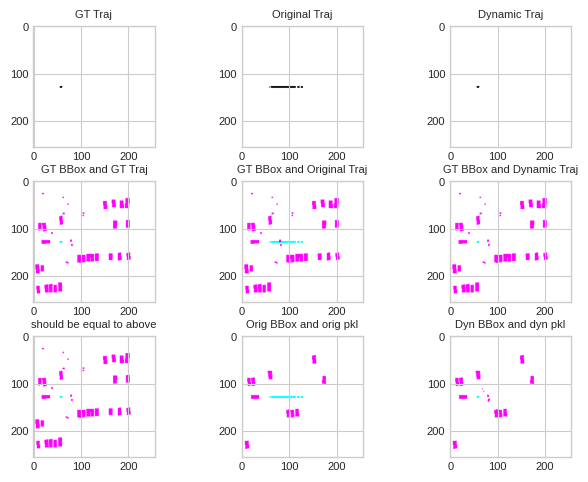

round completed
elaborating token: 2bb5509e49344af9a6dd61dddab5a859
loading pkl model
loading pkl model
pkl original: 321.3092346191406 pkl dynamic: 9.638595581054688
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

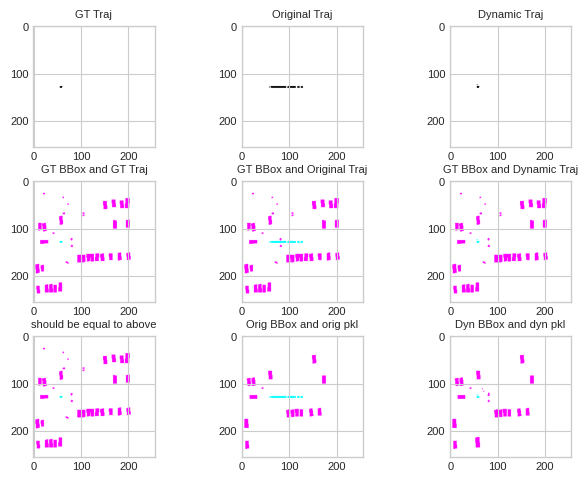

round completed
elaborating token: c05110b8ec93423dbf2f39b916f16979
loading pkl model
loading pkl model
pkl original: 277.1097717285156 pkl dynamic: 0.6491200923919678
collision with trajectory original and ground truth for token c05110b8ec93423dbf2f39b916f16979
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

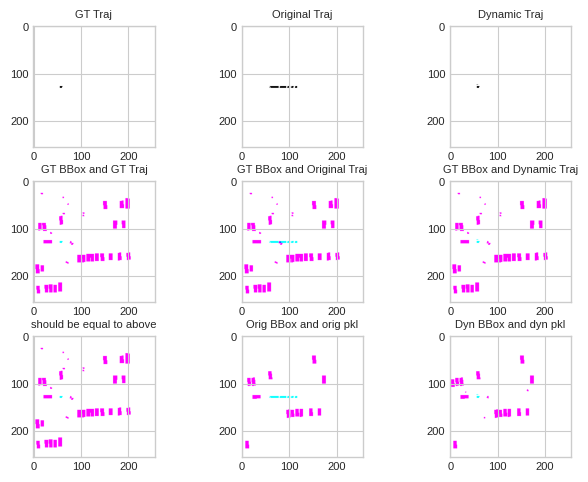

round completed
elaborating token: 8398a7b012a04b00a72951ce2792e9d6
loading pkl model
loading pkl model
pkl original: 237.7625732421875 pkl dynamic: 0.2507941722869873
collision with trajectory original and ground truth for token 8398a7b012a04b00a72951ce2792e9d6
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

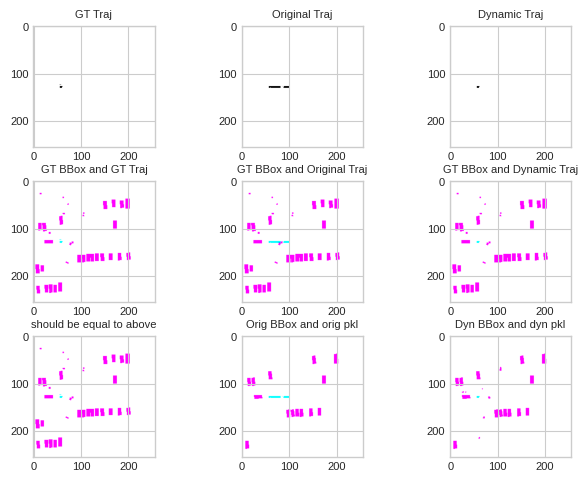

round completed
elaborating token: d11353f29481498487eef6a6661060a4
loading pkl model
loading pkl model
pkl original: 208.83184814453125 pkl dynamic: 46.621463775634766
collision with trajectory original and ground truth for token d11353f29481498487eef6a6661060a4
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

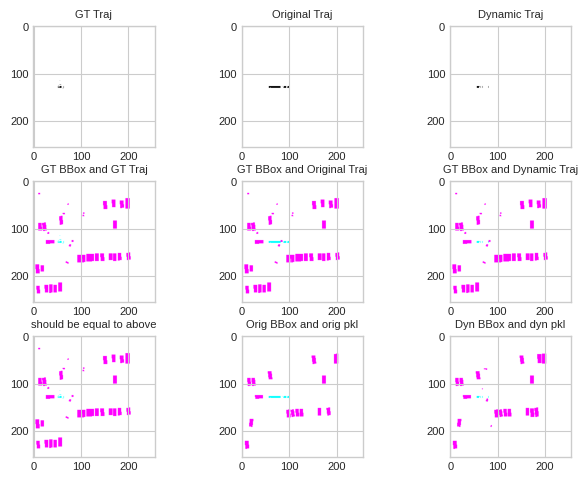

round completed
elaborating token: 339ead96177c4e338fde8235c188cfaa
loading pkl model
loading pkl model
pkl original: 105.53256225585938 pkl dynamic: 17.353988647460938
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

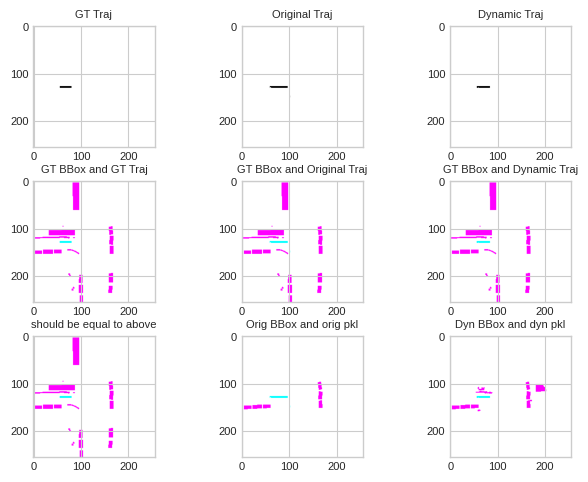

round completed
elaborating token: e3f82cd4e586448c98105270a72938a1
loading pkl model
loading pkl model
pkl original: 78.56306457519531 pkl dynamic: 12.616558074951172
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

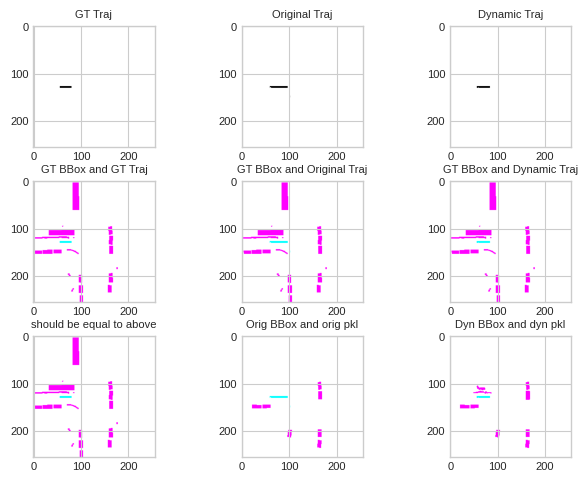

round completed
elaborating token: 2633bccdf64b40d7be34af01670de69a
loading pkl model
loading pkl model
pkl original: 57.75658416748047 pkl dynamic: 12.262988090515137
collision with trajectory original and ground truth for token 2633bccdf64b40d7be34af01670de69a
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

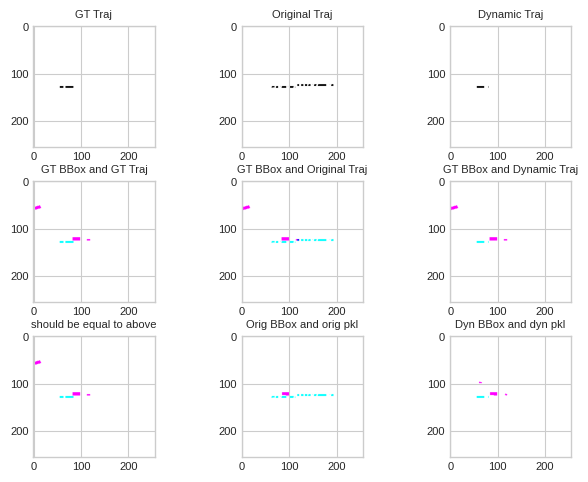

round completed
elaborating token: f5b3786fe6734f288e15a434c6dafbc9
loading pkl model
loading pkl model
pkl original: 53.351104736328125 pkl dynamic: 12.43416976928711
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

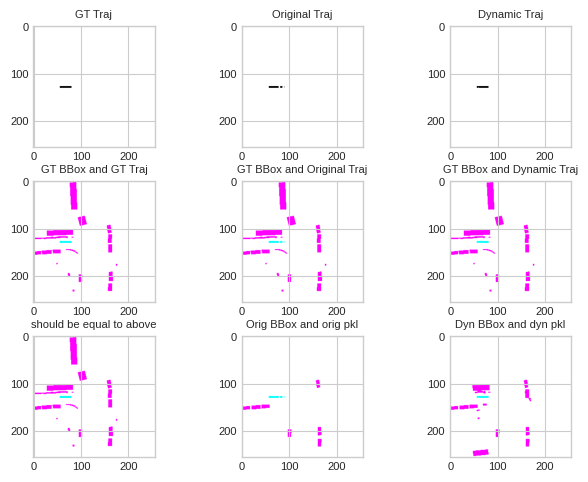

round completed
elaborating token: 05f93990849242aa80941e1ac8384c76
loading pkl model
loading pkl model
pkl original: 71.21318817138672 pkl dynamic: 31.373640060424805
collision with trajectory ground truth and ground truth bboxes for token 05f93990849242aa80941e1ac8384c76
collision with trajectory original and ground truth for token 05f93990849242aa80941e1ac8384c76
collision with trajectory dynamic -our approach- and ground truth bboxes for token 05f93990849242aa80941e1ac8384c76
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

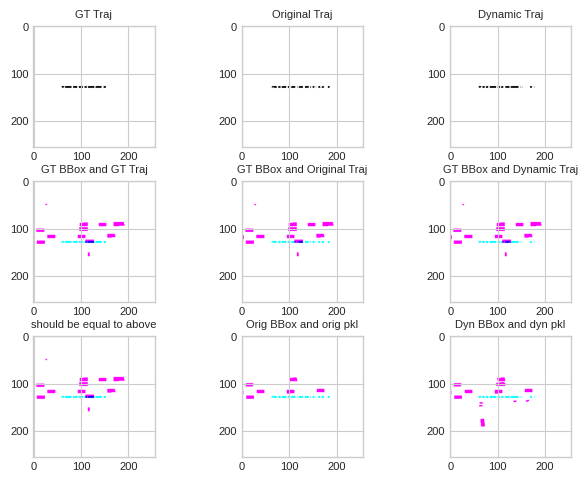

round completed
elaborating token: 745e6a480cbc42fab8d91b73f9a2fd6a
loading pkl model
loading pkl model
pkl original: 87.80040740966797 pkl dynamic: 49.637943267822266
collision with trajectory ground truth and ground truth bboxes for token 745e6a480cbc42fab8d91b73f9a2fd6a
collision with trajectory original and ground truth for token 745e6a480cbc42fab8d91b73f9a2fd6a
collision with trajectory dynamic -our approach- and ground truth bboxes for token 745e6a480cbc42fab8d91b73f9a2fd6a
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

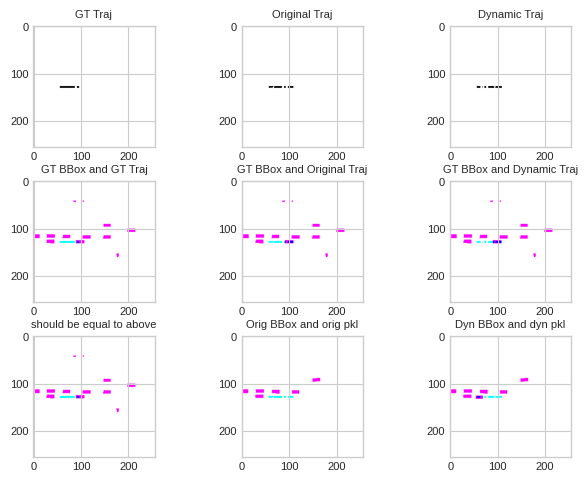

round completed
elaborating token: a1bbde13230e4493a2bacce82acf9456
loading pkl model
loading pkl model
pkl original: 33.29498291015625 pkl dynamic: 3.5515971183776855
collision with trajectory original and ground truth for token a1bbde13230e4493a2bacce82acf9456
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

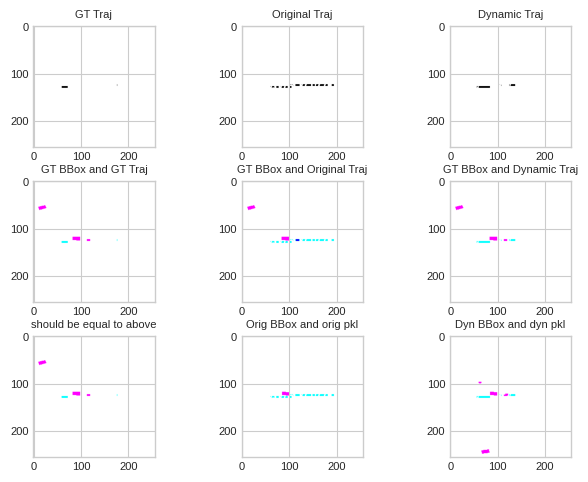

round completed
elaborating token: a42f9468a2d54dd786875764ec2d3496
loading pkl model
loading pkl model
pkl original: 46.79018783569336 pkl dynamic: 20.500581741333008
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

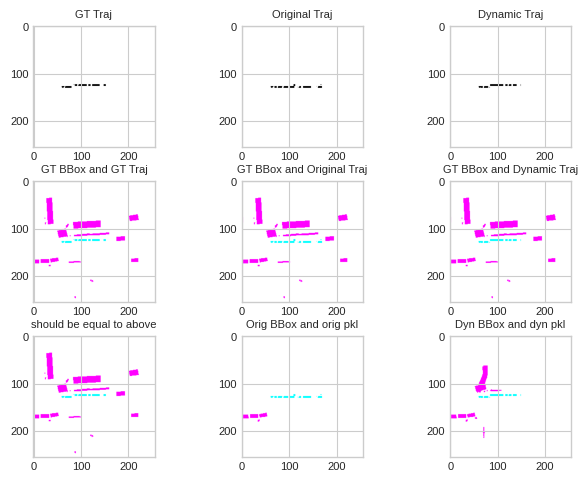

round completed
elaborating token: 0c23d9c6329d40938e1f0593c15f1e70
loading pkl model


KeyboardInterrupt: 

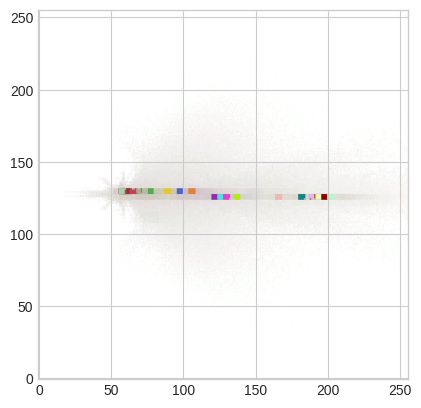

In [111]:
number_of_trajectory_poses=16 #4 seconds prediction

TRAJ_POINTS=20 #for every frame, we pick the top 20 trajectory points. This 20 comes from pkl functions. 

%matplotlib inline
font=8

for token in TOKEN_LIST_IN_USE:
    print("elaborating token: {}".format(token))
    pklfile_dynamic, info_dynamic, all_pkls_dynamic, \
    gtdist, preddist_dynamic, gtxs, \
    predxs_dynamic, createdimages_dynamic=dt.calc_sample_crit_GOAL2_unique_param(listtoken=[token],
                                         conf_th=threshold,
                                         crit=crit,
                                         obj_classes_list=object_classes,#filter boxes based on class
                                         verbose=verbose)

    pklfile_original,info_original,all_pkls_original,gtdist,preddist_original,gtxs,\
    predxs_original,\
    createdimages_original=dt.calc_sample_crit_GOAL2_unique_param(listtoken=[token],
                                         conf_th=threshold,
                                         crit=10.00,
                                         obj_classes_list=object_classes,#filter boxes based on class
                                         verbose=verbose)
    

    print("pkl original: {} pkl dynamic: {}".format(info_original['mean'], info_dynamic['mean']))
    #get the ground truth bboxes
    sGT=createdimages_original[0]['heat_gt']
    ground_truths=createdimages_original[0]['gtx'].cpu().numpy()[3]
    ground_truths=np.swapaxes(ground_truths,0,1)
    
    #get the ground truth trajectory
    dimension=sGT[0][0].cpu().numpy().shape
    basic_shape=np.zeros(dimension)    
    trajectory_gt=basic_shape
    for i in range(0,number_of_trajectory_poses):
        #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
        tmp=sGT[i][0].cpu().numpy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory_gt=np.add(trajectory_gt,tmp)
        
    trajectory_gt[trajectory_gt>0]=1
    #trajectory_gt[trajectory_gt<THRESHOLD]=0
    trajectory_gt=np.swapaxes(trajectory_gt, 0,1)   
    
    #get the predicted original bboxes
    sPT=createdimages_original[0]['heat_pt']
    original_detections=createdimages_original[0]['ptx'].cpu().numpy()[3]
    original_detections=np.swapaxes(original_detections,0,1)
    
    #get the predicted original trajectories
    trajectory_pt=basic_shape
    for i in range(0,number_of_trajectory_poses):
        #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
        tmp=sPT[i][0].cpu().numpy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory_pt=np.add(trajectory_pt,tmp)

    trajectory_pt[trajectory_pt>0]=1
    #trajectory_pt[trajectory_pt<THRESHOLD]=0
    trajectory_pt=np.swapaxes(trajectory_pt, 0,1)

    #ground truth with dynamic object - just for check
    sDT_GT=createdimages_dynamic[0]['heat_gt']
    ground_truths_dt=createdimages_dynamic[0]['gtx'].cpu().numpy()[3]
    ground_truths_dt=np.swapaxes(ground_truths_dt,0,1)
    
    trajectory_gt_dt=basic_shape
    for i in range(0,number_of_trajectory_poses):
        #trajectory_gt_dt=np.add(trajectory_gt_dt,sDT_GT[i][0].cpu().numpy())
        #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
        tmp=sDT_GT[i][0].cpu().numpy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory_gt_dt=np.add(trajectory_gt_dt,tmp)

    trajectory_gt_dt[trajectory_gt_dt>0]=1
    #trajectory_gt_dt[trajectory_gt_dt<THRESHOLD]=0
    trajectory_gt_dt=np.swapaxes(trajectory_gt_dt, 0,1)   
    
    #get the predicted dynamic (our approach) bboxes
    sDT=createdimages_dynamic[0]['heat_pt']
    dynamic_detections=createdimages_dynamic[0]['ptx'].cpu().numpy()[3]
    dynamic_detections=np.swapaxes(dynamic_detections,0,1)

    #get the predicted dynamic (our approach) trajectories
    trajectory_dt=basic_shape
    for i in range(0,number_of_trajectory_poses):
        #trajectory_dt=np.add(trajectory_dt,sDT[i][0].cpu().numpy())
        #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
        tmp=sDT[i][0].cpu().numpy()
        tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
        tmp.fill(0)
        flat=tmp.flatten()
        flat[tmp_most_relevant_index]=1
        tmp=np.reshape(flat, dimension)
        trajectory_dt=np.add(trajectory_dt,tmp)
        
    trajectory_dt[trajectory_dt>0]=1
    #trajectory_dt[trajectory_dt<THRESHOLD]=0
    trajectory_dt=np.swapaxes(trajectory_dt, 0,1)

    #overlap with distance
    #ground truth
    final_gt=np.add(trajectory_gt, ground_truths)
    if 2 in final_gt:
        print("collision with trajectory ground truth and ground truth bboxes for token {}".format(token))
        with open(RESULTS_PATH+'GOAL2.txt', 'a+') as f:
            f.write("collision with trajectory ground truth and ground truth bboxes for token {}\n".format(token))
    #original
    final_pt=np.add(trajectory_pt, ground_truths)
    if 2 in final_pt:
        print("collision with trajectory original and ground truth for token {}".format(token))
        with open(RESULTS_PATH+'GOAL2.txt', 'a+') as f:
            f.write("collision with trajectory original and ground truth for token {}\n".format(token))
    #ground truth with dynamic object -- just for test
    final_gt_dt=np.add(trajectory_gt_dt, ground_truths)
#    if 2 in final_gt_dt:
#        print("collision with trajectory dynamic -our approach- and ground truth bboxes for token {}".format(token))
#        with open(RESULTS_PATH+'GOAL2.txt', 'a+') as f:
#            f.write("collision with trajectory dynamic -our approach- and ground truth bboxes for token {}\n".format(token))

    #dynamic
    final_dt=np.add(trajectory_dt, ground_truths)
    if 2 in final_dt:
        print("collision with trajectory dynamic -our approach- and ground truth bboxes for token {}".format(token))
        with open(RESULTS_PATH+'GOAL2.txt', 'a+') as f:
            f.write("collision with trajectory dynamic -our approach- and ground truth bboxes for token {}\n".format(token))

    print("printing figures...")

    plt.clf()
    plt.figure()
    fig, (ax) = plt.subplots(3,3)
    ax[0,0].tick_params(axis='both', labelsize=font)
    ax[0,1].tick_params(axis='both', labelsize=font)
    ax[0,2].tick_params(axis='both', labelsize=font)
    ax[1,0].tick_params(axis='both', labelsize=font)
    ax[1,1].tick_params(axis='both', labelsize=font)
    ax[1,2].tick_params(axis='both', labelsize=font)
    ax[2,0].tick_params(axis='both', labelsize=font)
    ax[2,1].tick_params(axis='both', labelsize=font)
    ax[2,2].tick_params(axis='both', labelsize=font)
    fig.tight_layout()

    ax[0,0].set_title('GT Traj', fontsize=font)
    ax[0,0].imshow(trajectory_gt)

    ax[0,1].set_title('Original Traj', fontsize=font)
    ax[0,1].imshow(trajectory_pt)

    ax[0,2].set_title('Dynamic Traj', fontsize=font)
    ax[0,2].imshow(trajectory_dt)

    ax[1,0].set_title('GT BBox and GT Traj', fontsize=font)
    image_gt=np.swapaxes(np.swapaxes(np.asarray([trajectory_gt,ground_truths,final_gt*0]),0, 2),0,1)
    ax[1,0].imshow(1-image_gt)

    ax[1,1].set_title('GT BBox and Original Traj', fontsize=font)
    image_pt=np.swapaxes(np.swapaxes(np.asarray([trajectory_pt,ground_truths,final_pt*0]),0, 2),0,1)
    ax[1,1].imshow(1-image_pt)

    ax[1,2].set_title('GT BBox and Dynamic Traj', fontsize=font)
    image_dt=np.swapaxes(np.swapaxes(np.asarray([trajectory_dt,ground_truths,final_dt*0]),0, 2),0,1)
    ax[1,2].imshow(1-image_dt)

    ax[2,0].set_title('should be equal to above', fontsize=font)
    image_gt_dt=np.swapaxes(np.swapaxes(np.asarray([trajectory_gt_dt,ground_truths_dt,final_gt_dt*0]),0, 2),0,1)
    ax[2,0].imshow(1-image_gt_dt)

    ax[2,1].set_title('Orig BBox and orig pkl', fontsize=font)
    image_pt=np.swapaxes(np.swapaxes(np.asarray([trajectory_pt,original_detections,final_pt*0]),0, 2),0,1)
    ax[2,1].imshow(1-image_pt)

    ax[2,2].set_title('Dyn BBox and dyn pkl', fontsize=font)
    image_dt=np.swapaxes(np.swapaxes(np.asarray([trajectory_dt,dynamic_detections,final_dt*0]),0, 2),0,1)
    ax[2,2].imshow(1-image_dt)
    plt.show()
    print("round completed")



**Now choose some interesting tokens. we present some detailed analysis. This includes making nice figures and understanding (if possible) the expected poisition after a certain time.**

ONE TOKEN AT THE TIME!

Used in the paper: 1f0a495a2b76420b9cadbc61723e1d46

In [127]:
TOKEN_UNDER_STUDY='8a6554684382497fa4ee6847fbe77f68'

In [128]:
threshold=0.25

loading pkl model


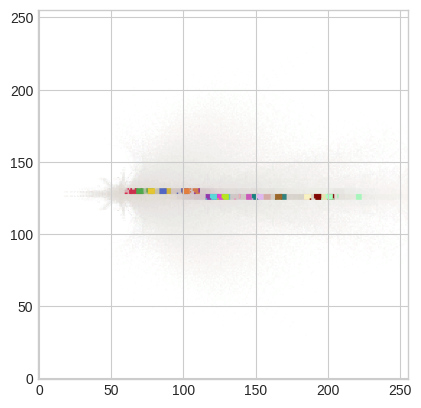

In [135]:
pklfile_dynamic, info_dynamic, all_pkls_dynamic, \
gtdist, preddist_dynamic, gtxs, \
predxs_dynamic, createdimages_dynamic=dt.calc_sample_crit_GOAL2_unique_param(listtoken=[TOKEN_UNDER_STUDY],
                                         conf_th=0.0,
                                         crit=10.0,
                                         obj_classes_list=object_classes,#filter boxes based on class
                                         verbose=verbose)


loading pkl model


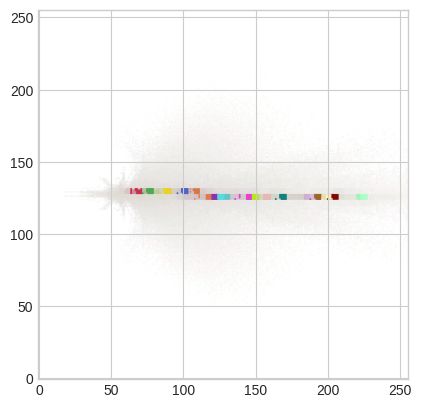

In [136]:
pklfile_original,info_original,all_pkls_original,gtdist,preddist_original,gtxs,\
predxs_original,\
createdimages_original=dt.calc_sample_crit_GOAL2_unique_param(listtoken=[TOKEN_UNDER_STUDY],
                                         conf_th=threshold,
                                         crit=10.00,
                                         obj_classes_list=object_classes,#filter boxes based on class
                                         verbose=verbose)

pkl original: 1.7597777843475342 pkl dynamic: 35.352134704589844
printing figures...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

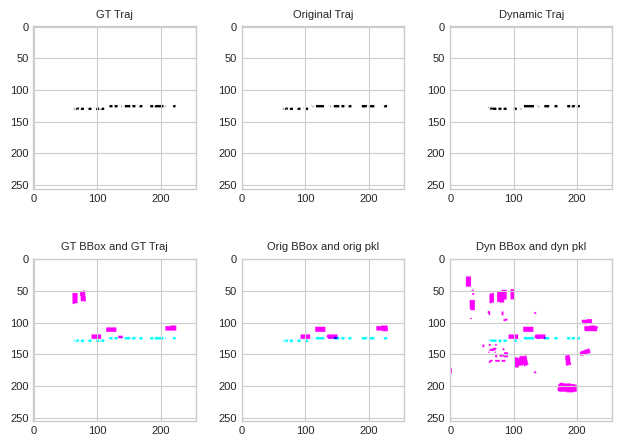

In [137]:
%matplotlib inline
font=8
number_of_trajectory_poses=16 #4 seconds prediction
TRAJ_POINTS=20 #for every frame, we pick the top 20 trajectory points. This 20 comes from pkl functions. 

print("pkl original: {} pkl dynamic: {}".format(info_original['mean'], info_dynamic['mean']))
#get the ground truth bboxes
sGT=createdimages_original[0]['heat_gt']
ground_truths=createdimages_original[0]['gtx'].cpu().numpy()[3]
ground_truths=np.swapaxes(ground_truths,0,1)
    
#get the ground truth trajectory
dimension=sGT[0][0].cpu().numpy().shape
basic_shape=np.zeros(dimension)    
trajectory_gt=basic_shape
for i in range(0,number_of_trajectory_poses):
    #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
    tmp=sGT[i][0].cpu().numpy()
    tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
    tmp.fill(0)
    flat=tmp.flatten()
    flat[tmp_most_relevant_index]=1
    tmp=np.reshape(flat, dimension)
    trajectory_gt=np.add(trajectory_gt,tmp)
        
trajectory_gt[trajectory_gt>0]=1
#trajectory_gt[trajectory_gt<THRESHOLD]=0
trajectory_gt=np.swapaxes(trajectory_gt, 0,1)   
    
#get the predicted original bboxes
sPT=createdimages_original[0]['heat_pt']
original_detections=createdimages_original[0]['ptx'].cpu().numpy()[3]
original_detections=np.swapaxes(original_detections,0,1)
    
#get the predicted original trajectories
trajectory_pt=basic_shape
for i in range(0,number_of_trajectory_poses):
    #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
    tmp=sPT[i][0].cpu().numpy()
    tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
    tmp.fill(0)
    flat=tmp.flatten()
    flat[tmp_most_relevant_index]=1
    tmp=np.reshape(flat, dimension)
    trajectory_pt=np.add(trajectory_pt,tmp)

trajectory_pt[trajectory_pt>0]=1
trajectory_pt=np.swapaxes(trajectory_pt, 0,1)

#get the predicted dynamic (our approach) bboxes
sDT=createdimages_dynamic[0]['heat_pt']
dynamic_detections=createdimages_dynamic[0]['ptx'].cpu().numpy()[3]
dynamic_detections=np.swapaxes(dynamic_detections,0,1)

#get the predicted dynamic (our approach) trajectories
trajectory_dt=basic_shape
for i in range(0,number_of_trajectory_poses):
    #get 20 most relevant points in sGT[i][0].cpu().numpy(), i.e., per frame
    tmp=sDT[i][0].cpu().numpy()
    tmp_most_relevant_index=np.argsort(tmp.flatten())[-TRAJ_POINTS:]
    tmp.fill(0)
    flat=tmp.flatten()
    flat[tmp_most_relevant_index]=1
    tmp=np.reshape(flat, dimension)
    trajectory_dt=np.add(trajectory_dt,tmp)
        
trajectory_dt[trajectory_dt>0]=1
trajectory_dt=np.swapaxes(trajectory_dt, 0,1)

#overlap with distance
#ground truth
final_gt=np.add(trajectory_gt, ground_truths)

#original
final_pt=np.add(trajectory_pt, ground_truths)

#dynamic
final_dt=np.add(trajectory_dt, ground_truths)

print("printing figures...")
plt.clf()
plt.figure()
fig, (ax) = plt.subplots(2,3)
ax[0,0].tick_params(axis='both', labelsize=font)
ax[0,1].tick_params(axis='both', labelsize=font)
ax[0,2].tick_params(axis='both', labelsize=font)
ax[1,0].tick_params(axis='both', labelsize=font)
ax[1,1].tick_params(axis='both', labelsize=font)
ax[1,2].tick_params(axis='both', labelsize=font)
fig.tight_layout()

ax[0,0].set_title('GT Traj', fontsize=font)
ax[0,0].imshow(trajectory_gt)

ax[0,1].set_title('Original Traj', fontsize=font)
ax[0,1].imshow(trajectory_pt)

ax[0,2].set_title('Dynamic Traj', fontsize=font)
ax[0,2].imshow(trajectory_dt)

ax[1,0].set_title('GT BBox and GT Traj', fontsize=font)
image_gt=np.swapaxes(np.swapaxes(np.asarray([trajectory_gt,ground_truths,final_gt*0]),0, 2),0,1)
ax[1,0].imshow(1-image_gt)

ax[1,1].set_title('Orig BBox and orig pkl', fontsize=font)
image_pt=np.swapaxes(np.swapaxes(np.asarray([trajectory_pt,original_detections,final_pt*0]),0, 2),0,1)
ax[1,1].imshow(1-image_pt)

ax[1,2].set_title('Dyn BBox and dyn pkl', fontsize=font)
image_dt=np.swapaxes(np.swapaxes(np.asarray([trajectory_dt,dynamic_detections,final_dt*0]),0, 2),0,1)
ax[1,2].imshow(1-image_dt)
plt.show()

In [140]:
LIGHT_GREY=0.8
DARK_GREY=0.4
#shape of image to be displayed
shape=(gtxs[0][4].shape[0],gtxs[0][4].shape[1],3)

#road is white with light gray borders
road=np.swapaxes(gtxs[0][0],0,1)
road[road!=1]=LIGHT_GREY

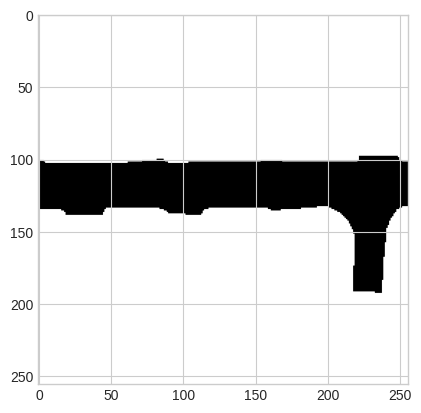

In [141]:
%matplotlib inline

plt.figure()
plt.imshow(road)
plt.show()

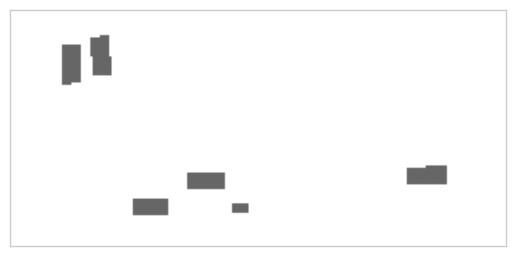

In [158]:
%matplotlib inline

figure=np.ones(shape)

#draw ego in red
ego_black=1-np.swapaxes(gtxs[0][4],0,1).numpy()
ego=np.ones(shape)
ego[:,:,1]=ego_black
ego[:,:,2]=ego_black

#draw ground truth in dark grey
all_bb_black=1-np.swapaxes(gtxs[0][3],0,1).numpy()
all_bb=np.ones(figure.shape)
all_bb[all_bb_black==0]=DARK_GREY

#combine ego and ground truth bboxes
all_bb[ego==0]=0

#add trajectory in black
all_bb[trajectory_gt==1]=0

figure=all_bb

plt.figure()
plt.title('ego, bboxes, and trajectory ground truth')
plt.imshow(figure)
plt.show()

#add road in light grey
figure[road==LIGHT_GREY]=LIGHT_GREY

plt.figure()
plt.title('ego, bboxes, and trajectory ground truth')
plt.grid(None)   
plt.imshow(figure)
plt.show()

#add road in light grey
figure[road==LIGHT_GREY]=LIGHT_GREY

plt.figure()
plt.title('ego, bboxes, and trajectory ground truth')
plt.grid(None)   
plt.imshow(figure)
plt.show()

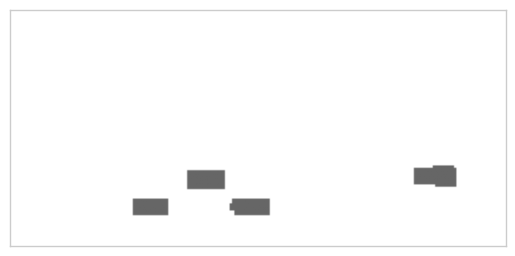

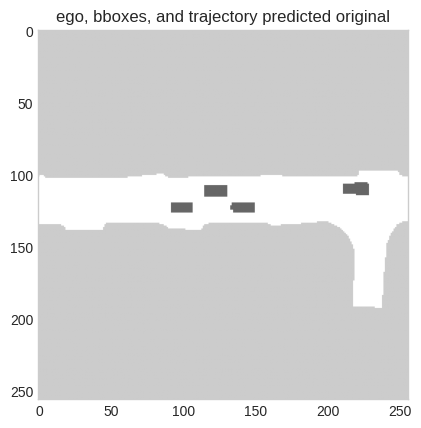

In [160]:
%matplotlib inline

figure=np.ones(shape)

#draw ego in red
ego_black=1-np.swapaxes(predxs_original[0][4],0,1).numpy()
ego=np.ones(shape)
ego[:,:,1]=ego_black
ego[:,:,2]=ego_black

#draw ground truth in dark grey
all_bb_black=1-np.swapaxes(predxs_original[0][3],0,1).numpy()
all_bb=np.ones(figure.shape)
all_bb[all_bb_black==0]=DARK_GREY

#combine ego and ground truth bboxes
all_bb[ego==0]=0

#add trajectory in black
all_bb[trajectory_pt==1]=0

figure=all_bb

plt.figure()
plt.title('ego, bboxes, and trajectory predicted original')
plt.imshow(figure)
plt.show()

#add road in light grey
figure[road==LIGHT_GREY]=LIGHT_GREY

plt.figure()
plt.title('ego, bboxes, and trajectory predicted original')
plt.grid(None)   
plt.imshow(figure)
plt.show()

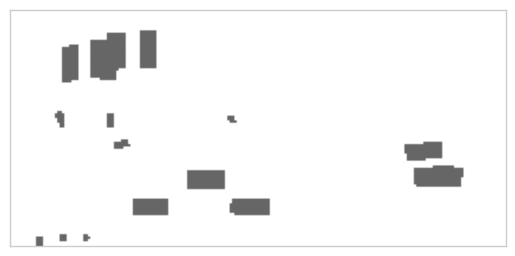

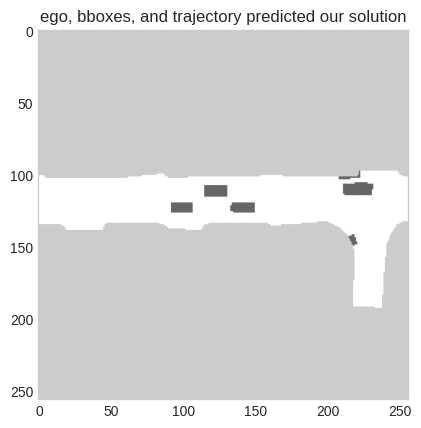

In [161]:
%matplotlib inline

figure=np.ones(shape)

#draw ego in red
ego_black=1-np.swapaxes(predxs_dynamic[0][4],0,1).numpy()
ego=np.ones(shape)
ego[:,:,1]=ego_black
ego[:,:,2]=ego_black

#draw ground truth in dark grey
all_bb_black=1-np.swapaxes(predxs_dynamic[0][3],0,1).numpy()
all_bb=np.ones(figure.shape)
all_bb[all_bb_black==0]=DARK_GREY

#combine ego and ground truth bboxes
all_bb[ego==0]=0

#add trajectory in black
all_bb[trajectory_dt==1]=0

figure=all_bb

plt.figure()
plt.title('ego, bboxes, and trajectory predicted our solution')
plt.imshow(figure)
plt.show()

#add road in light grey
figure[road==LIGHT_GREY]=LIGHT_GREY

plt.figure()
plt.title('ego, bboxes, and trajectory predicted our solution')
plt.grid(None)   
plt.imshow(figure)
plt.show()

**Next would be to estimate the position with X frames, if from our examples it look it is relevant.**

**But first let's see if we have examples that requires this.**